## ASSIGNMENT-2
Roll Numbers:

Names:

### Instructions
 * Fill in the roll numbers and names of all the teams members in the cell above.
 * Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
 * All the code and result files should be uploaded in the github classroom.
 * You can use the in-built methods and **unless explicitly mentioned**, don't need to code from scratch for this assignment. Make sure your code is modular since you will be reusing them for future assignments.
 * All the representations are expected to be in a right-hand coordinate system. All the functions related to transformation matrices, quaternions, and 3D projection are expected to be coded by you.
 * You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.
 * All the visualization should be done inside the notebook unless specified otherwise.
 * Plagiarism will lead to heavy penalty.

## G2O Motion Model 

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive nodes k and k+1.

## PART 2

### 1. ICP Alignment with LieTorch (5 marks)
Resources: https://github.com/princeton-vl/lietorch/tree/master

Perform ICP Alignment of 2 PointClouds using LieTorch. Similar to what was expected in Part 1, you will be given a random Transformation matrix from the getTransform function. You are expected to transform the Toothless Point Cloud by this transformation, add noise to both sets of points (original and transformed) and estimate both, the Transformation matrix and the original point cloud.

Visualize your results using open3d

In [1]:
import numpy as np
import math
import torch
from lietorch import SO3
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
## Random Transform Implementation
import numpy as np
import math
import torch
from lietorch import SO3
import open3d as o3d

def alpha_rot(alpha):
    return np.array([
        [   1.0,    0.0,                0.0             ],
        [   0.0,    math.cos(alpha),   -math.sin(alpha) ],
        [   0.0,    math.sin(alpha),    math.cos(alpha) ]
        ],dtype=np.float32)

def beta_rot(beta):
    return np.array([
        [   math.cos(beta),     0.0,    math.sin(beta)  ],
        [   0.0,                1.0,    0.0             ],
        [  -math.sin(beta),     0.0,    math.cos(beta)  ]
        ],dtype=np.float32)

def gamma_rot(gamma):
    return np.array([
        [   math.cos(gamma),   -math.sin(gamma),    0.0 ],
        [   math.sin(gamma),    math.cos(gamma),    0.0 ],
        [   0.0,                0.0,                1.0 ]
        ],dtype=np.float32)
        
def euler2rm(alpha, beta, gamma):
    return np.matmul(alpha_rot(alpha),np.matmul(beta_rot(beta),gamma_rot(gamma)))

def getTransform():
    R = euler2rm(np.random.uniform(0, 2 * np.pi),
                 np.random.uniform(0, 2 * np.pi),
                 np.random.uniform(0, 2 * np.pi))
    T = np.array([
        [np.random.uniform(-500, 500)],
        [np.random.uniform(-500, 500)],
        [np.random.uniform(-500, 500)]
    ])
    
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = R
    transformation_matrix[:3, 3] = T.flatten()
    
    return transformation_matrix

def invert_transform(matrix):
    rotation_matrix = matrix[:3, :3]
    translation_vector = matrix[:3, 3]

    inv_rotation_matrix = np.transpose(rotation_matrix)
    inv_translation_vector = -np.matmul(inv_rotation_matrix, translation_vector)

    inv_matrix = np.eye(4)
    inv_matrix[:3, :3] = inv_rotation_matrix
    inv_matrix[:3, 3] = inv_translation_vector
    
    return inv_matrix

def transform_point_cloud(point_cloud, transformation_matrix, downsample=1.0):
    if downsample < 1.0:
        indices = np.arange(0, point_cloud.shape[0], int(1.0 / downsample))
        point_cloud = point_cloud[indices]

    rotated_points = np.dot(point_cloud, transformation_matrix[:3, :3].T)
    transformed_points = rotated_points + transformation_matrix[:3, 3]

    return transformed_points

def rsme(pcl0, pcl1, transform):
    return np.linalg.norm(pcl0 - transform_point_cloud(pcl1, transform)) / np.sqrt(pcl0.shape[0])


In [7]:
import numpy as np
import lietorch
import torch
import open3d as o3d
import matplotlib.pyplot as plt

def alpha_rot(alpha):
    return np.array([
        [   1.0,    0.0,                0.0             ],
        [   0.0,    math.cos(alpha),   -math.sin(alpha) ],
        [   0.0,    math.sin(alpha),    math.cos(alpha) ]
        ],dtype=np.float32)

def beta_rot(beta):
    return np.array([
        [   math.cos(beta),     0.0,    math.sin(beta)  ],
        [   0.0,                1.0,    0.0             ],
        [  -math.sin(beta),     0.0,    math.cos(beta)  ]
        ],dtype=np.float32)

def gamma_rot(gamma):
    return np.array([
        [   math.cos(gamma),   -math.sin(gamma),    0.0 ],
        [   math.sin(gamma),    math.cos(gamma),    0.0 ],
        [   0.0,                0.0,                1.0 ]
        ],dtype=np.float32)
        
def euler2rm(alpha, beta, gamma):
    return np.matmul(alpha_rot(alpha),np.matmul(beta_rot(beta),gamma_rot(gamma)))

def getTransform():
    R = euler2rm(np.random.uniform(0, 2 * np.pi),
                 np.random.uniform(0, 2 * np.pi),
                 np.random.uniform(0, 2 * np.pi))
    T = np.array([
        [np.random.uniform(-500, 500)],
        [np.random.uniform(-500, 500)],
        [np.random.uniform(-500, 500)]
    ])
    
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = R
    transformation_matrix[:3, 3] = T.flatten()
    
    return transformation_matrix

def transform_point_cloud(point_cloud, transformation_matrix, downsample=1.0):
    if downsample < 1.0:
        indices = np.arange(0, point_cloud.shape[0], int(1.0 / downsample))
        point_cloud = point_cloud[indices]

    rotated_points = np.dot(point_cloud, transformation_matrix[:3, :3].T)
    transformed_points = rotated_points + transformation_matrix[:3, 3]

    return transformed_points



pcl = o3d.io.read_point_cloud('data/toothless.ply')

transform0 = getTransform()
transform1 = getTransform()
pcl_array = np.array(pcl.points)

downsample = 1

pcl0 = transform_point_cloud(pcl_array, transform0, downsample)
pcl1 = transform_point_cloud(pcl_array + np.random.normal(0.0, 1, pcl_array.shape), transform1, downsample)






'\nYOUR CODE HERE\n'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Converged in 3 iterations with 1.7460628760877113 error.


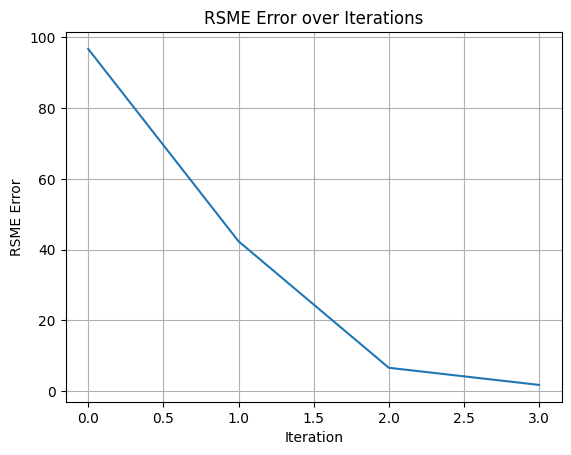

In [1]:
import numpy as np
import lietorch
import torch
import open3d as o3d
import matplotlib.pyplot as plt

def rsme(pcl0, pcl1, transform):
    return np.linalg.norm(pcl0 - transform_point_cloud(pcl1, transform)) / np.sqrt(pcl0.shape[0])

# Convert to torch tensor
def transform_point_cloud(point_cloud, se3_transform):
    # Get the 4x4 transformation matrix from SE3 object using .matrix()
    transform_matrix = se3_transform.matrix()  # or .mat if supported in the version

    # Apply rotation and translation
    rotated_points = torch.matmul(point_cloud, transform_matrix[:3, :3].T)  # Extracts the 3x3 rotation part
    transformed_points = rotated_points + transform_matrix[:3, 3]  # Applies the 3x1 translation part

    return transformed_points

def skew(vector):
    """
    Create a skew-symmetric matrix from a 3D vector.
    """
    x, y, z = vector.ravel()
    return torch.tensor([
        [ 0, -z,  y],
        [ z,  0, -x],
        [-y,  x,  0]
    ], dtype=torch.float32)

# Use this skew function inside your code
def icp_with_lie(pcl0, pcl1, guess_transform):
    """
    Perform ICP using SE(3) Lie algebra and lietorch for optimization.
    """
    # Transform pcl1 with the current guess transformation
    pcl1_transformed = transform_point_cloud(pcl1, guess_transform)

    # Compute residuals (difference between pcl0 and transformed pcl1)
    residuals = pcl1_transformed - pcl0
    
    # Flatten residuals to a column vector
    residuals = residuals.reshape(-1, 1)
    
    # Use Lie group logarithm map to compute the transformation update
    delta_x = guess_transform.log()  # Get the 6D twist (se3)
    
    # Jacobian: We can use a simplified method leveraging Lie groups
    jacobian = torch.zeros((pcl1.shape[0] * 3, 6), dtype=torch.float32)

    for j in range(pcl1_transformed.shape[0]):
        # Rotation part (identity block for translation)
        jacobian[3 * j: 3 * j + 3, 0:3] = torch.eye(3)

        # Translation part (skew-symmetric matrix for rotation)
        jacobian[3 * j: 3 * j + 3, 3:6] = -skew(pcl1_transformed[j].view(-1))
    
    # Solve using least squares (optimize in the Lie algebra space)
    delta_x = -torch.linalg.lstsq(jacobian.T @ jacobian, jacobian.T @ residuals).solution
    
    # Ensure delta_x is the correct shape
    delta_x = delta_x.squeeze()  # Make sure delta_x is 1D with shape (6,)
    
    # Update the guess transform by applying the delta (in SE(3) space)
    updated_transform = lietorch.SE3.exp(delta_x).mul(guess_transform)
    
    return updated_transform


errors = []

# Load point cloud
pcl = o3d.io.read_point_cloud('data/toothless.ply')
pcl_array = np.array(pcl.points)
pcl_tensor = torch.tensor(pcl_array, dtype=torch.float32)

# Initial transformations using LieTorch SE(3)
transform0 = lietorch.SE3.exp(torch.randn(6))
transform1 = lietorch.SE3.exp(torch.randn(6))

# Downsample
downsample = 0.1
pcl0 = transform_point_cloud(pcl_tensor, transform0)
pcl1 = transform_point_cloud(pcl_tensor + torch.randn_like(pcl_tensor), transform1)

# Set up Open3D visualization
pcl0_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl0.numpy()))
frame0 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])
pcl0_geom.paint_uniform_color([1.0, 0.0, 0.0])

pcl1_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl1.numpy()))
frame1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])
pcl1_geom.paint_uniform_color([0.0, 0.0, 1.0])

vis = o3d.visualization.Visualizer()
vis.create_window()

vis.add_geometry(pcl0_geom)
vis.add_geometry(frame0)
vis.add_geometry(pcl1_geom)
vis.add_geometry(frame1)

vis.poll_events()
vis.update_renderer()

# Iterative optimization loop
opti_transform = lietorch.SE3.exp(torch.randn(6))

for i in range(20):
    # Perform ICP step and update the transformation
    opti_transform = icp_with_lie(pcl0, pcl1, opti_transform)

    # Transform pcl1 using the updated guess
    pcl1_transformed = transform_point_cloud(pcl1, opti_transform)
    pcl1_geom.points = o3d.utility.Vector3dVector(pcl1_transformed.numpy())

    # Update visualization
    vis.update_geometry(pcl1_geom)
    vis.update_geometry(frame1)
    vis.poll_events()
    vis.update_renderer()

    # Compute RSME error (you'll need to implement this function)
    error = rsme(pcl0, pcl1, opti_transform)
    errors.append(error)
    
    # Check for convergence
    if error < 2e-0:
        pcl0_geom.paint_uniform_color([0.0, 1.0, 0.0])
        pcl1_geom.paint_uniform_color([0.0, 1.0, 0.0])
        vis.update_geometry(pcl0_geom)
        vis.update_geometry(pcl1_geom)
        print(f"Converged in {i} iterations with {error} error.")
        break

if error > 2e-0:
    print("Failed to converge")
    
vis.run()
vis.destroy_window()

plt.plot(errors)
plt.xlabel('Iteration')
plt.ylabel('RSME Error')
plt.title('RSME Error over Iterations')
plt.grid()
plt.show()


Converged in 19 iterations with 1.9819 error.


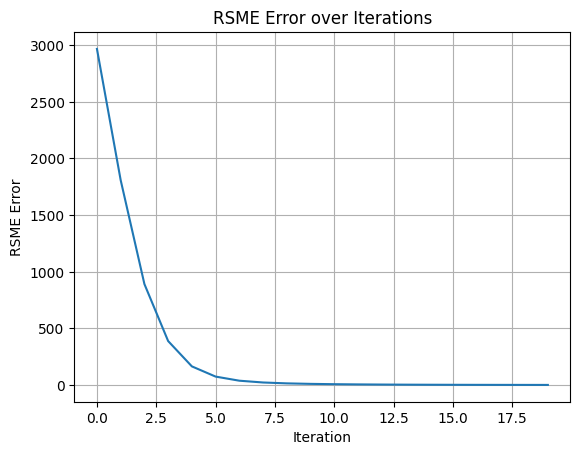

In [4]:
import numpy as np
import lietorch
import torch
import torch.optim as optim
import open3d as o3d
import matplotlib.pyplot as plt

# Convert to torch tensor
def transform_point_cloud(point_cloud, se3_transform):
    # Get the 4x4 transformation matrix from SE3 object using .matrix()
    transform_matrix = se3_transform.matrix()

    # Apply rotation and translation
    rotated_points = torch.matmul(point_cloud, transform_matrix[:3, :3].T)  # 3x3 rotation
    transformed_points = rotated_points + transform_matrix[:3, 3]  # 3x1 translation

    return transformed_points

def skew(vector):
    """
    Create a skew-symmetric matrix from a 3D vector.
    """
    x, y, z = vector.ravel()
    return torch.tensor([
        [0, -z, y],
        [z, 0, -x],
        [-y, x, 0]
    ], dtype=torch.float32)

# Loss function (e.g., residual sum of squares)
def compute_loss(pcl0, pcl1_transformed):
    residuals = pcl1_transformed - pcl0
    loss = torch.mean(residuals ** 2)  # L2 norm (squared residuals)
    return loss

# Load point cloud
pcl = o3d.io.read_point_cloud('data/toothless.ply')
pcl_array = np.array(pcl.points)
pcl_tensor = torch.tensor(pcl_array, dtype=torch.float32)

# Initial transformations using LieTorch SE(3)
transform0 = lietorch.SE3.exp(torch.randn(6))
transform1 = lietorch.SE3.exp(torch.randn(6))

# Downsample the point cloud (optional)
downsample = 0.1
pcl0 = transform_point_cloud(pcl_tensor, transform0)
pcl1 = transform_point_cloud(pcl_tensor + torch.randn_like(pcl_tensor), transform1)

# Set up Open3D visualization
pcl0_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl0.numpy()))
frame0 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])
pcl0_geom.paint_uniform_color([1.0, 0.0, 0.0])

pcl1_geom = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl1.numpy()))
frame1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100.0, origin=[0, 0, 0])
pcl1_geom.paint_uniform_color([0.0, 0.0, 1.0])

vis = o3d.visualization.Visualizer()
vis.create_window()

vis.add_geometry(pcl0_geom)
vis.add_geometry(frame0)
vis.add_geometry(pcl1_geom)
vis.add_geometry(frame1)

vis.poll_events()
vis.update_renderer()

# Initialize the transformation parameter (6D vector in Lie algebra)
transformation_param = torch.randn(6, requires_grad=True)

# Define optimizer with learning rate and momentum
lr_init = 1e-4  # Learning rate
optimizer = optim.SGD([transformation_param], lr=lr_init, momentum=0.1)

errors = []

# Iterative optimization loop (Gradient Descent)
for i in range(20):
    optimizer.zero_grad()  # Zero the gradients
    
    # Convert 6D parameter to SE(3) using the exponential map
    opti_transform = lietorch.SE3.exp(transformation_param)
    
    # Transform pcl1 using the updated guess
    pcl1_transformed = transform_point_cloud(pcl1, opti_transform)
    
    # Compute the loss (residuals)
    loss = compute_loss(pcl0, pcl1_transformed)
    
    # Backpropagate the loss
    loss.backward()
    
    # Step the optimizer (Gradient Descent with momentum)
    optimizer.step()

    # Update the visualization with the transformed pcl1
    pcl1_geom.points = o3d.utility.Vector3dVector(pcl1_transformed.detach().numpy())
    vis.update_geometry(pcl1_geom)
    vis.update_geometry(frame1)
    vis.poll_events()
    vis.update_renderer()
    
    # Store and print error for each iteration
    error = loss.item()
    errors.append(error)
    
    if error < 2e-0:
        pcl0_geom.paint_uniform_color([0.0, 1.0, 0.0])
        pcl1_geom.paint_uniform_color([0.0, 1.0, 0.0])
        vis.update_geometry(pcl0_geom)
        vis.update_geometry(pcl1_geom)
        print(f"Converged in {i} iterations with {error:.4f} error.")
        break

if error > 2e-0:
    print("Failed to converge")

# Close visualization window
vis.run()
vis.destroy_window()

# Plot the error (RSME) over iterations
plt.plot(errors)
plt.xlabel('Iteration')
plt.ylabel('RSME Error')
plt.title('RSME Error over Iterations')
plt.grid()
plt.show()


### 2. ICP-SLAM with LieTorch (10 marks)

For this part, you will be given a set of `N` transformation matrices (Each relative to position 0). Add a random amount of noise to each of the `N` sets of points. Estimate the Transforms as well as the original point cloud using LieTorch.

Visualize your results using open3d

In [ ]:
def getTransforms():
    # Output shape - (n, 4, 4)
    pass

In [ ]:
'''
YOUR CODE HERE
'''